# Transformer

```{note}
Transformer作为编码器-解码器结构的一个实例，它完全基于注意力机制，核心是多头注意力，其整体结构图如下图所示。<br/>
前面几节，我们介绍了Transformer的各个组件，本节我们要把它们拼起来。
```

![jupyter](../images/10/transformer.svg)

## 编码器

下面的`EncoderBlock`类实现了示意图左边的虚线框，它包含两个子层：多头注意力和基于位置的前馈网络，这两个子层都使用了残差连接和紧随的层归一化。

In [1]:
import torch
from torch import nn
import d2l
import math


class EncoderBlock(nn.Module):
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_hiddens, num_heads, 
                 dropout, use_bias=False):
        super(EncoderBlock, self).__init__()
        # 多头注意力
        self.attention = d2l.MultiHeadAttention(key_size, query_size,
                                                value_size, num_hiddens,
                                                num_heads, dropout, use_bias)
        # 第一个add&norm
        self.addnorm1 = d2l.AddNorm(norm_shape, dropout)
        # positionwiseFFN
        self.ffn = d2l.PositionWiseFFN(num_hiddens, ffn_num_hiddens)
        # 第二个add&norm
        self.addnorm2 = d2l.AddNorm(norm_shape, dropout)

    def forward(self, X, valid_lens):
        # `X` shape: (`batch_size`, `num_steps`, `num_hiddens`)
        # 第一个子层
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        # 第二个子层，形状不变
        return self.addnorm2(Y, self.ffn(Y))

In [2]:
class TransformerEncoder(d2l.Encoder):
    """Transformer的编码器"""
    def __init__(self, vocab_size, num_hiddens, 
                 norm_shape, ffn_num_hiddens, num_heads, 
                 num_layers, dropout, use_bias=False):
        super(TransformerEncoder, self).__init__()
        self.num_hiddens = num_hiddens
        # Embedding将输入从`vocab_size`变为`num_hiddens`
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        # 位置编码
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        # 各个EncoderBlock
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module(
                "block" + str(i),
                EncoderBlock(num_hiddens, num_hiddens, num_hiddens, num_hiddens,
                             norm_shape, ffn_num_hiddens, num_heads, 
                             dropout, use_bias))

    def forward(self, X, valid_lens):
        # 因为位置编码值在-1到1之间，因此需要进行平方根缩放，保持它们在一个量级
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        for blk in self.blks:
            X = blk(X, valid_lens)
        return X

## 解码器

如结构图所示，Transformer的解码器也是由多个结构相同的层组成。

`DecoderBlock`包含三个子层：解码器自注意力、"编码器-解码器"注意力和基于位置的前馈网络。

在遮蔽多头自注意力层（Masked multi-head attention，第一层）中，查询、键和值都来自于上一个解码器层的输出。在训练阶段，输出序列所有时间步的词元都是已知的；然而，在预测阶段，其输出序列的词元是逐个生成的。

In [3]:
class DecoderBlock(nn.Module):
    """解码器中的第i个块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_hiddens, num_heads, 
                 dropout, i):
        super(DecoderBlock, self).__init__()
        self.i = i
        self.attention1 = d2l.MultiHeadAttention(key_size, query_size,
                                                 value_size, num_hiddens,
                                                 num_heads, dropout)
        self.addnorm1 = d2l.AddNorm(norm_shape, dropout)
        self.attention2 = d2l.MultiHeadAttention(key_size, query_size,
                                                 value_size, num_hiddens,
                                                 num_heads, dropout)
        self.addnorm2 = d2l.AddNorm(norm_shape, dropout)
        self.ffn = d2l.PositionWiseFFN(num_hiddens, ffn_num_hiddens)
        self.addnorm3 = d2l.AddNorm(norm_shape, dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # `state[2][self.i]` 用于预测阶段，初始化为None，它存储截止目前时间步的的输出序列
        # 训练和第一个token的预测
        if state[2][self.i] is None:
            key_values = X
        # 后续预测
        else:
            # 跟RNN-seq2seq不一样，Transformer预测要用到截止目前的输出序列，而不只是上一
            # 时间步的输出
            key_values = torch.cat((state[2][self.i], X), axis=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            # 防作弊
            # shape of dec_valid_lens: (`batch_size`, `num_steps`)
            # 其中每一行是 [1, 2, ..., `num_steps`]
            dec_valid_lens = torch.arange(1, num_steps + 1, 
                                          device=X.device).repeat(batch_size, 1)
        else:
            # 预测时token by token就不用了
            dec_valid_lens = None
        # Self-attention
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        # Encoder-decoder attention
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

In [4]:
class TransformerDecoder(d2l.Decoder):
    """Transformer解码器"""
    def __init__(self, vocab_size, num_hiddens, 
                 norm_shape, ffn_num_hiddens, num_heads, 
                 num_layers, dropout):
        super(TransformerDecoder, self).__init__()
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        # 各个DecoderBlock
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module(
                "block" + str(i),
                DecoderBlock(num_hiddens, num_hiddens, num_hiddens, num_hiddens,
                             norm_shape, ffn_num_hiddens, num_heads, 
                             dropout, i))
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        # 给state[2]留位置
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]

    def forward(self, X, state):
        # 常规操作
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
        return self.dense(X), state

## 训练

In [5]:
# 载入数据
batch_size, num_steps = 64, 10
train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

In [6]:
# 一些参数
num_hiddens, num_layers, dropout = 32, 2, 0.1
ffn_num_hiddens, num_heads = 64, 4
norm_shape = [32]
lr, num_epochs, device = 0.005, 100, d2l.try_gpu()
# 创建模型
encoder = TransformerEncoder(len(src_vocab), num_hiddens, norm_shape,
                             ffn_num_hiddens, num_heads, num_layers, dropout)
decoder = TransformerDecoder(len(tgt_vocab), num_hiddens, norm_shape,
                             ffn_num_hiddens, num_heads, num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)

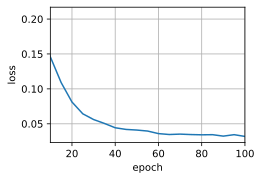

In [7]:
# 训练
d2l.train_nmt(net, train_iter, lr, num_epochs, tgt_vocab)

## 预测

In [8]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
# 预测并使用BLEU评估
for eng, fra in zip(engs, fras):
    translation = d2l.predict_nmt(net, eng, src_vocab, tgt_vocab, num_steps)
    print(f'{eng} => {translation}, bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => <unk> !, bleu 0.000
i lost . => j'ai perdu ., bleu 1.000
he's calm . => il est calme ., bleu 1.000
i'm home . => je suis chez moi ., bleu 1.000
